# Kaggle & Colab Imports

In [ ]:
%%capture
# KAGGLE IMPORTS
# Clone repo
!git clone https://github.com/francinze/Ch_An2DL.git /kaggle/working/ch2

# Install kaggle API
!pip install -q kaggle

# Configure kaggle.json
!mkdir -p /root/.config/kaggle

# Copy your kaggle.json there
!cp /kaggle/working/ch2/kaggle.json /root/.config/kaggle/

# Set correct permissions
!chmod 600 /root/.config/kaggle/kaggle.json

# Move into the working directory
%cd /kaggle/working/ch2/

!mkdir -p data
!mkdir -p models

# Download competition files WITH CORRECT PATH
!kaggle competitions download -c an2dl2526c2v2 -p ./data/

# Unzip dataset WITH CORRECT PATH
!unzip -o ./data/an2dl2526c2v2.zip -d ./data/

# Verify download
!ls -la ./data/
!echo "Download complete!"

In [ ]:
'''
%%capture
# COLAB IMPORTS
!git clone https://github.com/francinze/Ch_An2DL.git
! pip install -q kaggle
! mkdir ~/.kaggle
! cp Ch_An2DL/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
%cd /content/Ch_An2DL/
!mkdir data
!mkdir models
!kaggle competitions download -c an2dl2526c2v2 -p /data
!unzip -o /data/an2dl2526c2v2.zip -d /data/
'''

#  Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Organize Data by Type

In [2]:
import os
import shutil

# Detect environment and set appropriate path prefix
if os.path.exists('./data/train_data'):
    PATH_PREFIX = './'
    print("✓ Found ./data/train_data (Local or Colab)")
elif os.path.exists('/data/train_data'):
    PATH_PREFIX = '/'
    print("✓ Found /data/train_data (Kaggle)")
elif os.path.exists('data/train_data'):
    PATH_PREFIX = ''
    print("✓ Found data/train_data (Current directory)")
else:
    print("✗ Data not found in expected locations!")
    PATH_PREFIX = '/'

print(f"Using PATH_PREFIX: {PATH_PREFIX}")

print("="*80)
print("ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE")
print("="*80)

# Define source directories
train_data_dir = PATH_PREFIX + 'data/train_data/'
test_data_dir = PATH_PREFIX + 'data/test_data/'

# Define target directories for organized data
train_img_dir = PATH_PREFIX + 'data/train_img/'
train_mask_dir = PATH_PREFIX + 'data/train_mask/'
test_img_dir = PATH_PREFIX + 'data/test_img/'
test_mask_dir = PATH_PREFIX + 'data/test_mask/'

train_labels = pd.read_csv(PATH_PREFIX + 'data/train_labels.csv')

# Create target directories if they don't exist
for directory in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to organize files by type
def organize_data_by_type(source_dir, img_dir, mask_dir):
    """
    Move image and mask files from source directory to separate directories.
    Only moves files if they don't already exist in the target directory.
    """
    if not os.path.exists(source_dir):
        print(f"⚠ Warning: Source directory not found: {source_dir}")
        return 0, 0
    
    files = os.listdir(source_dir)
    img_count = 0
    mask_count = 0
    
    for filename in files:
        source_path = os.path.join(source_dir, filename)
        
        # Skip if not a file
        if not os.path.isfile(source_path):
            continue
        
        # Determine target directory based on filename prefix
        if filename.startswith('img_'):
            target_path = os.path.join(img_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                img_count += 1
        elif filename.startswith('mask_'):
            target_path = os.path.join(mask_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                mask_count += 1
    
    return img_count, mask_count

# Organize training data
print("\nOrganizing training data...")
train_img_moved, train_mask_moved = organize_data_by_type(
    train_data_dir, train_img_dir, train_mask_dir
)
print(f"  Images: {train_img_moved} files copied to {train_img_dir}")
print(f"  Masks: {train_mask_moved} files copied to {train_mask_dir}")

# Organize test data
print("\nOrganizing test data...")
test_img_moved, test_mask_moved = organize_data_by_type(
    test_data_dir, test_img_dir, test_mask_dir
)
print(f"  Images: {test_img_moved} files copied to {test_img_dir}")
print(f"  Masks: {test_mask_moved} files copied to {test_mask_dir}")

# Verify organization
print("\n" + "="*80)
print("DATA ORGANIZATION SUMMARY")
print("="*80)
print(f"Train images: {len(os.listdir(train_img_dir)) if os.path.exists(train_img_dir) else 0} files in {train_img_dir}")
print(f"Train masks: {len(os.listdir(train_mask_dir)) if os.path.exists(train_mask_dir) else 0} files in {train_mask_dir}")
print(f"Test images: {len(os.listdir(test_img_dir)) if os.path.exists(test_img_dir) else 0} files in {test_img_dir}")
print(f"Test masks: {len(os.listdir(test_mask_dir)) if os.path.exists(test_mask_dir) else 0} files in {test_mask_dir}")
print("="*80)
print("Data organization complete!")
print("  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/")

✓ Found ./data/train_data (Local or Colab)
Using PATH_PREFIX: ./
ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE

Organizing training data...
  Images: 0 files copied to ./data/train_img/
  Masks: 0 files copied to ./data/train_mask/

Organizing test data...
  Images: 0 files copied to ./data/test_img/
  Masks: 0 files copied to ./data/test_mask/

DATA ORGANIZATION SUMMARY
Train images: 581 files in ./data/train_img/
Train masks: 581 files in ./data/train_mask/
Test images: 477 files in ./data/test_img/
Test masks: 477 files in ./data/test_mask/
Data organization complete!
  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/


# Preprocessing

## Remove Shrek & Slimes

In [3]:
# Parse the contaminated indices from the text file
contaminated_indices = []
with open('shrek_and_slimes.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line and line.isdigit():
            contaminated_indices.append(int(line))

print(f"Found {len(contaminated_indices)} contaminated samples to remove")

# Define directories to clean (both img and mask directories)
train_img_dir_clean = PATH_PREFIX + 'data/train_img/'
train_mask_dir_clean = PATH_PREFIX + 'data/train_mask/'

# Remove corresponding image and mask files from both directories
removed_count = 0
for idx in contaminated_indices:
    img_name = f'img_{idx:04d}.png'
    mask_name = f'mask_{idx:04d}.png'
    
    # Remove from train_img directory
    img_path = os.path.join(train_img_dir_clean, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1
    
    # Remove from train_mask directory
    mask_path = os.path.join(train_mask_dir_clean, mask_name)
    if os.path.exists(mask_path):
        os.remove(mask_path)
        removed_count += 1

print(f"Removed {removed_count} files from organized directories")

# Update train_labels by removing contaminated indices
train_labels = train_labels[~train_labels['sample_index'].str.extract(r'(\d+)')[0].astype(int).isin(contaminated_indices)]
print(f"Training labels updated: {len(train_labels)} samples remaining")

Found 110 contaminated samples to remove
Removed 0 files from organized directories
Training labels updated: 581 samples remaining


## Masks as Focus Filters

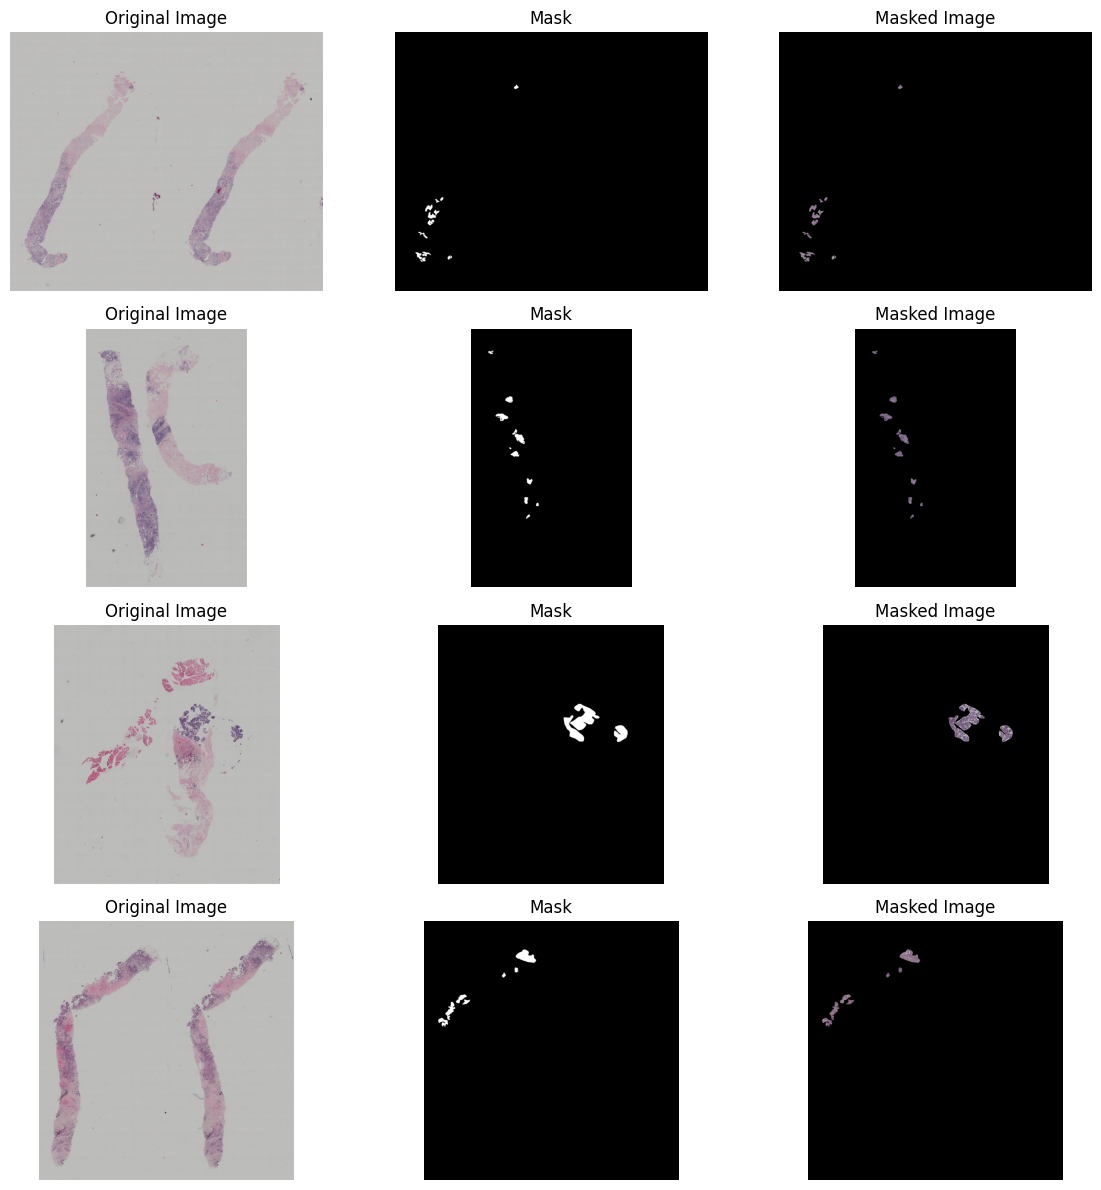

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# === FUNZIONE CHE APPLICA LA MASK ALL’IMMAGINE ===
def apply_mask(image, mask):
    """
    image: PIL RGB image
    mask: PIL grayscale mask (0 = nero, 255 = bianco)
    return: masked image (PIL)
    """

    # Converti in numpy
    img_np = np.array(image).astype(np.uint8)
    mask_np = np.array(mask).astype(np.uint8)

    # Normalizza la mask a 0–1
    mask_np = mask_np / 255.0

    # Se l’immagine ha 3 canali, estendi la mask
    if img_np.ndim == 3:
        mask_np = np.expand_dims(mask_np, axis=-1)

    # Moltiplica → le zone nere diventano 0 (nero)
    masked_img_np = (img_np * mask_np).astype(np.uint8)

    return Image.fromarray(masked_img_np)

# === VISUALIZZA A VIDEO ALCUNI ESEMPI ===
samples = sorted(os.listdir(train_img_dir))[:4]  # primi 4 esempi

fig, axes = plt.subplots(len(samples), 2, figsize=(12, 2 * len(samples)))

for i, img_name in enumerate(samples):

    # Carica immagine e mask corrispondente
    img_path = os.path.join(train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Applica la mask
    masked_image = apply_mask(image, mask)

    # --- Plot ---
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masked_image)
    axes[i, 1].set_title("Masked Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
from tqdm import tqdm

# Save masked images to a new directory
masked_train_img_dir = PATH_PREFIX + 'data/train_img_masked/'
os.makedirs(masked_train_img_dir, exist_ok=True)
masked_test_img_dir = PATH_PREFIX + 'data/test_img_masked/'
os.makedirs(masked_test_img_dir, exist_ok=True)

# Apply masking to all training images and save
train_img_files = sorted(os.listdir(train_img_dir))

for img_name in tqdm(train_img_files, desc="Processing training images"):
    img_path = os.path.join(train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    masked_image = apply_mask(image, mask)
    masked_image.save(os.path.join(masked_train_img_dir, img_name))
print("Masked training images saved.")

# Apply masking to all test images and save
test_img_files = sorted(os.listdir(test_img_dir))
for img_name in tqdm(test_img_files, desc="Processing test images"):
    img_path = os.path.join(test_img_dir, img_name)
    mask_path = os.path.join(test_mask_dir, img_name.replace("img_", "mask_"))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    masked_image = apply_mask(image, mask)
    masked_image.save(os.path.join(masked_test_img_dir, img_name))

print("Masked test images saved.")

Processing training images: 100%|██████████| 581/581 [01:08<00:00,  8.47it/s]


Masked training images saved.


Processing test images: 100%|██████████| 477/477 [00:55<00:00,  8.67it/s]

Masked test images saved.


## Augmentation


Class Distribution After Removal of Contaminated Images
label
HER2(+)            150
Luminal A          158
Luminal B          204
Triple negative     69
Name: count, dtype: int64

Total samples: 581

STATISTICS FOR AUGMENTATION

Class with the most samples (Majority): Luminal B (204 samples)
Class with the fewest samples (Minority): Triple negative (69 samples)

Imbalance ratio (Max/Min): 2.96x

RECOMMENDED AUGMENTATION STRATEGY

Augmentations to apply (as suggested by the professor):
  1. Horizontal Flip (p=0.5)
  2. Vertical Flip (p=0.5)
  3. Random Translation (0.2, 0.2)
  4. Random Zoom/Scale (0.8, 1.2)
  [EXCLUDE: Random Rotation - would change dimensions]


BALANCED STRATEGY: ALL CLASSES GROW TO A FIXED AND EQUAL NUMBER

Target: 250 samples for EACH class

DATASET AFTER BALANCED AUGMENTATION
Class                Original        New Augment     Augmentations per image   Total          
--------------------------------------------------------------------------------
HER2(+)      

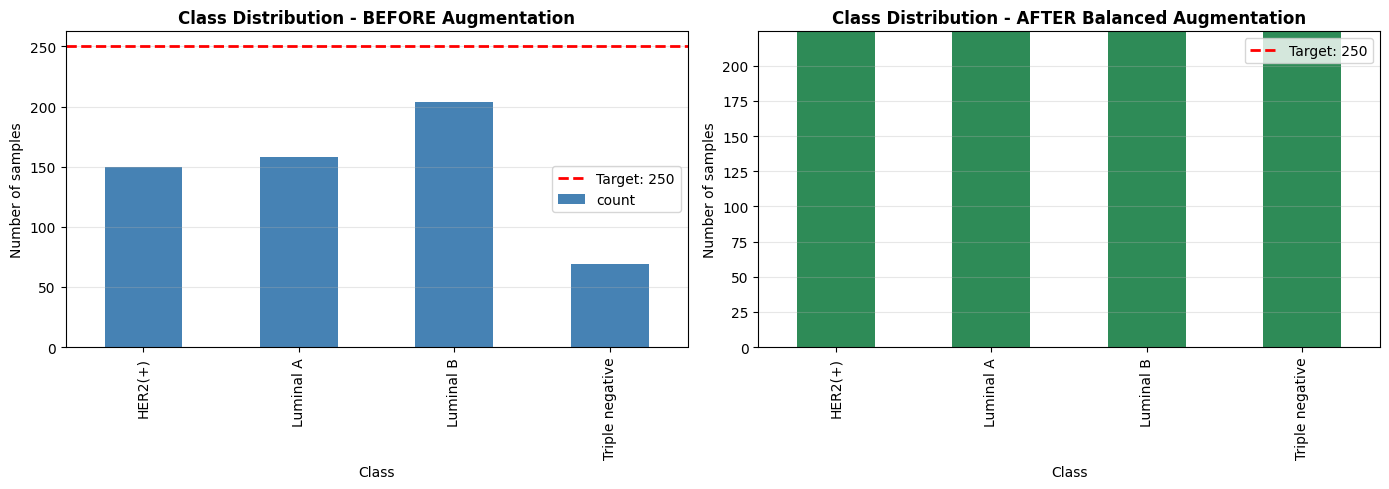

In [6]:
import matplotlib.pyplot as plt

# Analyze class distribution after removal
class_distribution = train_labels['label'].value_counts().sort_index()
print("\n" + "="*60)
print("Class Distribution After Removal of Contaminated Images")
print("="*60)
print(class_distribution)
print(f"\nTotal samples: {len(train_labels)}")

# Calculate statistics
print("\n" + "="*60)
print("STATISTICS FOR AUGMENTATION")
print("="*60)

# Class with the most samples (majority)
max_class = class_distribution.max()
max_class_name = class_distribution.idxmax()
print(f"\nClass with the most samples (Majority): {max_class_name} ({max_class} samples)")

# Class with the fewest samples (minority)
min_class = class_distribution.min()
min_class_name = class_distribution.idxmin()
print(f"Class with the fewest samples (Minority): {min_class_name} ({min_class} samples)")

# Imbalance ratio
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (Max/Min): {imbalance_ratio:.2f}x")

# Augmentation proposal
print("\n" + "="*60)
print("RECOMMENDED AUGMENTATION STRATEGY")
print("="*60)
print("\nAugmentations to apply (as suggested by the professor):")
print("  1. Horizontal Flip (p=0.5)")
print("  2. Vertical Flip (p=0.5)")
print("  3. Random Translation (0.2, 0.2)")
print("  4. Random Zoom/Scale (0.8, 1.2)")
print("  [EXCLUDE: Random Rotation - would change dimensions]\n")

# STRATEGY: All classes grow until reaching the same target number for ALL
print("\n" + "="*80)
print("BALANCED STRATEGY: ALL CLASSES GROW TO A FIXED AND EQUAL NUMBER")
print("="*80)

# ===== MODIFY THE TARGET NUMBER OF SAMPLES HERE =====
target_samples = 250  # Desired number of samples for EACH class
# =====================================================

print(f"\nTarget: {target_samples} samples for EACH class")

augmentation_strategy_balanced = {}
total_to_generate = 0

for class_name in class_distribution.index:
    n_samples = class_distribution[class_name]
    n_needed = target_samples - n_samples
    n_augmentations = max(0, n_needed)  # We cannot have negative augmentations
    
    augmentation_strategy_balanced[class_name] = {
        'original': n_samples,
        'target': target_samples,
        'augment_count': n_augmentations,
        'ratio_multiplier': n_augmentations / n_samples if n_samples > 0 else 0
    }
    
    total_to_generate += n_augmentations

# Projection of the dataset after augmentation
print("\n" + "="*80)
print("DATASET AFTER BALANCED AUGMENTATION")
print("="*80)
print(f"{'Class':<20} {'Original':<15} {'New Augment':<15} {'Augmentations per image':<25} {'Total':<15}")
print("-" * 80)

total_original = 0
total_augmented = 0
for class_name in class_distribution.index:
    n_original = class_distribution[class_name]
    n_aug = augmentation_strategy_balanced[class_name]['augment_count']
    n_total = n_original + n_aug
    
    total_original += n_original
    total_augmented += n_total
    
    print(f"{class_name:<20} {n_original:<15} {n_aug:<15} {augmentation_strategy_balanced[class_name]['ratio_multiplier']:<25.2f} {n_total:<15}")

print("-" * 80)
print(f"{'TOTAL':<20} {total_original:<15} {total_to_generate:<15} {np.mean([augmentation_strategy_balanced[class_name]['ratio_multiplier'] for class_name in class_distribution.index]):<25.2f} {total_augmented:<15}")

# Visualize the distribution before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
class_distribution.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Class Distribution - BEFORE Augmentation', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of samples')
axes[0].set_xlabel('Class')
axes[0].axhline(y=target_samples, color='red', linestyle='--', linewidth=2, label=f'Target: {target_samples}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# After
after_augmentation_balanced = {}
for class_name in class_distribution.index:
    after_augmentation_balanced[class_name] = augmentation_strategy_balanced[class_name]['target']

after_series = pd.Series(after_augmentation_balanced)
after_series.plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Class Distribution - AFTER Balanced Augmentation', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of samples')
axes[1].set_xlabel('Class')
axes[1].axhline(y=target_samples, color='red', linestyle='--', linewidth=2, label=f'Target: {target_samples}')
axes[1].set_ylim([0, max_class * 1.1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
from torchvision import transforms

# Create folder for augmented data if it doesn't exist
augmented_dir = PATH_PREFIX + f'data/train_data_augmented/'
train_dir = PATH_PREFIX + 'data/train_img_cropped/'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
    print(f"Created directory: {augmented_dir}")
else:
    existing_files = len(os.listdir(augmented_dir))
    print(f"Directory already exists: {augmented_dir}")
    print(f"Found {existing_files} existing augmented files")

# Define augmentations for each class
# Using expand=True in RandomRotation to preserve aspect ratio and prevent cropping
augmentation_transforms = {
    'flip': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180, expand=True, fill=0)  # expand=True prevents cropping, fill=0 for black padding
    ]),
}

print("\n" + "="*80)
print("STARTING AUGMENTATION PROCESS")
print("="*80)

# Loop through each class and generate augmentations
total_augmented = 0

for class_name in sorted(augmentation_strategy_balanced.keys()):
    info = augmentation_strategy_balanced[class_name]
    n_augment = info['augment_count']
    
    if n_augment == 0:
        print(f"\n{class_name}: No augmentation needed (already at target)")
        continue
    
    print(f"\n{'-'*80}")
    print(f"Class: {class_name}")
    print(f"Augmentations to generate: {n_augment}")
    print(f"{'-'*80}")
    
    # Get original images of this class
    class_samples = train_labels[train_labels['label'] == class_name]['sample_index'].tolist()
    n_original = len(class_samples)
    
    # Calculate how many augmentations per original image
    aug_per_img = n_augment / n_original
    
    # For each original image
    aug_count = 0
    for img_idx, img_name in enumerate(class_samples):
        # Determine which file to load based on DATA_TYPE
        file_name = img_name
        
        img_path = os.path.join(masked_train_img_dir, file_name)
        
        if not os.path.exists(img_path):
            print(f"  File not found: {file_name}")
            continue
        
        # Load the original image/mask
        img = Image.open(img_path).convert('RGB')
        img_pil = img.copy()
        
        # Generate augmentations for this image
        n_to_generate = int(np.ceil(aug_per_img)) if img_idx < n_augment % n_original else int(np.floor(aug_per_img))
        
        for aug_num in range(n_to_generate):
            if aug_count <= n_augment:
                base_name = file_name.replace('.png', '')

                # Choose an augmentation type cyclically
                aug_types = list(augmentation_transforms.keys())
                aug_type = aug_types[aug_count % len(aug_types)]
                transform = augmentation_transforms[aug_type]
                img_augmented = transform(img_pil)
                augmented_img_name = f"{base_name}_aug_{aug_num}_{aug_type}.png"
                
                # Save augmented image
                augmented_img_path = os.path.join(augmented_dir, augmented_img_name)
                img_augmented.save(augmented_img_path)
                
            aug_count += 1
        
        # Progress update
        if (img_idx + 1) % max(1, n_original // 5) == 0 or img_idx == n_original - 1:
            print(f"  Processed {img_idx + 1}/{n_original} original samples ({aug_count} augmentations generated)")
    
    total_augmented += aug_count
    print(f"  {class_name}: Completed! {aug_count} augmentations generated")

print("\n" + "="*80)
print(f"AUGMENTATION COMPLETED!")
print(f"Total augmented images generated: {total_augmented}")
print(f"Save directory: {augmented_dir}")
print("="*80)

# Verify file countprint(f"First 5 files: {augmented_files[:5]}")
augmented_files = os.listdir(augmented_dir)
print(f"\nFiles in augmented folder: {len(augmented_files)}")

Directory already exists: ./data/train_data_augmented/
Found 419 existing augmented files

STARTING AUGMENTATION PROCESS

--------------------------------------------------------------------------------
Class: HER2(+)
Augmentations to generate: 100
--------------------------------------------------------------------------------
  Processed 30/150 original samples (30 augmentations generated)
  Processed 60/150 original samples (60 augmentations generated)
  Processed 90/150 original samples (90 augmentations generated)
  Processed 120/150 original samples (100 augmentations generated)
  Processed 150/150 original samples (100 augmentations generated)
  HER2(+): Completed! 100 augmentations generated

--------------------------------------------------------------------------------
Class: Luminal A
Augmentations to generate: 92
--------------------------------------------------------------------------------
  Processed 31/158 original samples (31 augmentations generated)
  Processed 62/1

## Crop Masked Images

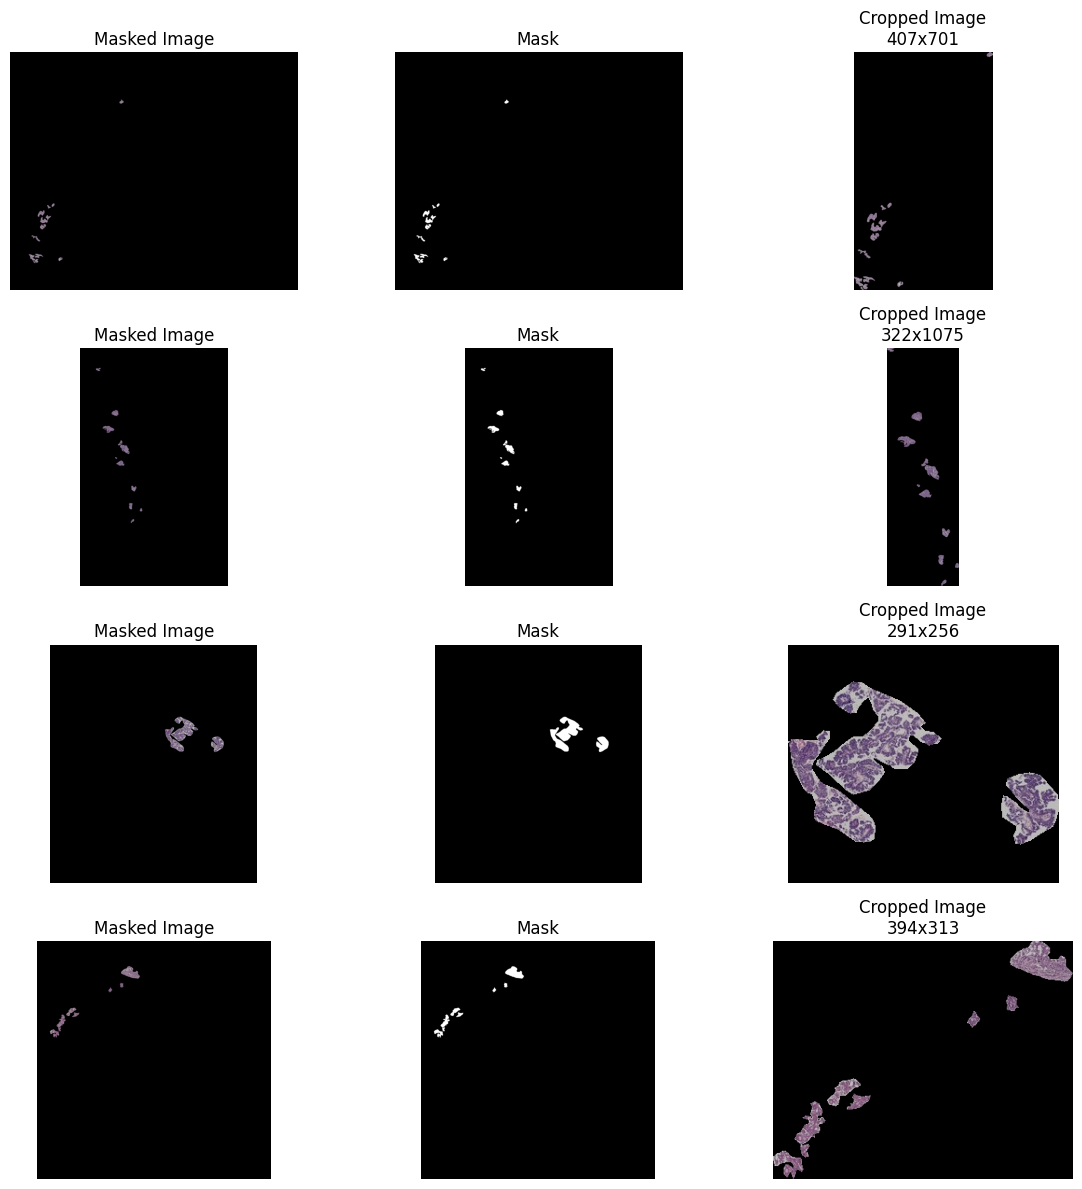

In [8]:
# Crop masked images to the extent of information
# Now that we have applied the masks, we can crop the images to the bounding box of the non-zero regions in the masks.

# Define minimum image size (will be used later in preprocessing)
MIN_IMG_SIZE = (256, 256)
def crop_to_mask(image, min_size=MIN_IMG_SIZE):
    """
    Crop the image to the bounding box of the non-zero regions.
    Since the mask has already been applied to the image, we detect non-zero pixels directly from the image.
    If the cropped image is smaller than min_size, add zero-padding to reach min_size.
    
    image: PIL RGB image (already masked, with black background)
    mask: PIL grayscale mask (not used, kept for compatibility)
    min_size: tuple (width, height) - minimum size for the output image
    return: cropped and padded image (PIL)
    """
    # Convert image to numpy array
    img_np = np.array(image).astype(np.uint8)
    
    # Find non-zero pixels in any channel (R, G, or B)
    # Sum across color channels and check where sum > 0
    non_zero_mask = np.sum(img_np, axis=2) > 0
    coords = np.column_stack(np.where(non_zero_mask))
    
    if coords.size == 0:
        return image  # No cropping if image is completely black
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0) + 1  # add 1 to include the max pixel
    
    cropped = image.crop((x_min, y_min, x_max, y_max))
    
    # Check if padding is needed
    width, height = cropped.size
    min_width, min_height = min_size
    
    if width < min_width or height < min_height:
        # Calculate padding needed
        pad_width = max(0, min_width - width)
        pad_height = max(0, min_height - height)
        
        # Create new image with black padding
        padded = Image.new('RGB', (max(width, min_width), max(height, min_height)), (0, 0, 0))
        
        # Paste cropped image in the center
        paste_x = pad_width // 2
        paste_y = pad_height // 2
        padded.paste(cropped, (paste_x, paste_y))
        
        return padded
    
    return cropped

# === VISUALIZZA A VIDEO ALCUNI ESEMPI DI CROP ===
samples = sorted(os.listdir(masked_train_img_dir))[:4]  # primi 4 esempi
fig, axes = plt.subplots(len(samples), 3, figsize=(12, 3 * len(samples)))

for i, img_name in enumerate(samples):
    # Carica immagine e mask corrispondente
    img_path = os.path.join(masked_train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Applica la mask
    masked_image = apply_mask(image, mask)

    # Esegui il crop con padding se necessario
    cropped_image = crop_to_mask(masked_image)

    # --- Plot ---
    axes[i, 0].imshow(masked_image)
    axes[i, 0].set_title("Masked Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(cropped_image)
    axes[i, 2].set_title(f"Cropped Image\n{cropped_image.size[0]}x{cropped_image.size[1]}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
from tqdm import tqdm
# Crop all images and save to new directories
# Define new directories for cropped images
cropped_train_img_dir = PATH_PREFIX + 'data/train_img_cropped/'
cropped_test_img_dir = PATH_PREFIX + 'data/test_img_cropped/'
os.makedirs(cropped_train_img_dir, exist_ok=True)
os.makedirs(cropped_test_img_dir, exist_ok=True)

# Process training images
for img_name in tqdm(os.listdir(masked_train_img_dir), desc="Processing training images"):
    img_path = os.path.join(masked_train_img_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_train_img_dir, img_name))
print("\nCropped training images saved.")
# Process test images
for img_name in tqdm(os.listdir(masked_test_img_dir), desc="Processing test images"):
    img_path = os.path.join(masked_test_img_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_test_img_dir, img_name))
print("\nCropped test images saved.")

# Crop also all augmented images
for img_name in tqdm(os.listdir(augmented_dir), desc="Processing augmented images"):
    img_path = os.path.join(augmented_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_train_img_dir, img_name))
print("\nCropped augmented images saved.")

Processing training images: 100%|██████████| 581/581 [00:33<00:00, 17.49it/s]



Cropped training images saved.


Processing test images: 100%|██████████| 477/477 [00:29<00:00, 16.13it/s]



Cropped test images saved.


Processing augmented images: 100%|██████████| 419/419 [00:37<00:00, 11.05it/s]


Cropped augmented images saved.


# Dataloaders

In [30]:
from torch.utils.data import TensorDataset, Dataset, DataLoader

# ===== PATCH-BASED PROCESSING SETTINGS =====
# Instead of resizing images to 224x224 (which loses detail),
# we extract patches at full resolution and process them separately
PATCH_SIZE = 256  # Size of each patch (256x256)
PATCH_STRIDE = 128
# ==========================================

# For backward compatibility when not using patches
IMG_SIZE = (224, 224) if not PATCH_SIZE and not PATCH_STRIDE else (PATCH_SIZE, PATCH_SIZE)

# Create DataLoaders
# Larger batch size for multi-GPU: DataParallel splits batch across GPUs
# With 2 GPUs: effective batch per GPU = BATCH_SIZE / 2
BATCH_SIZE = 128  # 64 per GPU with DataParallel

# ===== GPU OPTIMIZATION SETTINGS =====
# Kaggle T4 x2 optimization: maximize data loading throughput
# Each T4 GPU can handle 4 workers efficiently
import torch
if torch.cuda.is_available():
    NUM_WORKERS = 2 * torch.cuda.device_count()  # 2 workers per GPU = 4 total for T4 x2
    PIN_MEMORY = True  # CRITICAL: Enables async CPU-to-GPU transfer while GPU computes
    PERSISTENT_WORKERS = True  # Keeps workers alive between epochs (faster)
    print(f"GPU detected: {torch.cuda.device_count()} GPU(s) - using {NUM_WORKERS} workers")
else:
    # CPU-only environment
    NUM_WORKERS = 0
    PIN_MEMORY = False
    PERSISTENT_WORKERS = False
# ======================================

# Load original + augmented images into tensors
print("\n" + "="*80)
print("LOADING CROPPED ORIGINAL + AUGMENTED IMAGES")
print("="*80)
print(f"Cropped directory: {cropped_train_img_dir}")

# Check if augmented directory exists and validate files
if not os.path.exists(augmented_dir):
    print(f"\nWARNING: Augmented directory does not exist!")
    print(f"Expected: {augmented_dir}")
    print(f"No augmented data will be loaded. Only original images will be used.")
    augmented_files = []
else:
    # Create list of augmented images
    augmented_files = os.listdir(augmented_dir)
    print(f"Augmented images found: {len(augmented_files)}")

# Create new dataframe with all images (original + augmented)
train_labels_augmented = train_labels.copy()

# Add augmented images
augmented_rows = []
for aug_img_name in augmented_files:
    # Extract original file name (works for both img_ and mask_ prefixes)
    # Format: {prefix}_{number}_aug_{aug_num}_{aug_type}.png
    base_name = aug_img_name.split('_aug_')[0] + '.png'
    
    original_row = train_labels[train_labels['sample_index'] == base_name]
    if not original_row.empty:
        class_label = original_row.iloc[0]['label']
        augmented_rows.append({'sample_index': aug_img_name, 'label': class_label})

augmented_df = pd.DataFrame(augmented_rows)
train_labels_augmented = pd.concat([train_labels_augmented, augmented_df], ignore_index=True)

print(f"\nOriginal dataset: {len(train_labels)} samples")
print(f"Augmented dataset: {len(train_labels_augmented)} samples")
print(f"\nDistribution in augmented dataset:")
print(train_labels_augmented['label'].value_counts().sort_index())

# ===== PRE-EXTRACT PATCHES TO DISK (RUN ONCE) =====
print("\n" + "="*80)
print("PATCH PRE-EXTRACTION (Multi-File Strategy)")
print("="*80)

# Directory to save pre-extracted patches
patches_dir = os.path.join(PATH_PREFIX, "data", "patches_cache")
os.makedirs(patches_dir, exist_ok=True)

# Metadata file to track all batch files
metadata_file = os.path.join(patches_dir, f"metadata_ps{PATCH_SIZE}_stride{PATCH_STRIDE}.json")

if os.path.exists(metadata_file):
    print(f"✓ Found pre-extracted patches!")
    print(f"  Loading metadata from: {metadata_file}")
    
    import json
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"✓ Found {metadata['num_batches']} batch files with {metadata['total_patches']} total patches")
    print(f"✓ Found {metadata['num_batches']} batch files with {metadata['total_patches']} total patches")
    
else:
    print(f"⚠ No pre-extracted patches found. Extracting now...")
    print(f"  Strategy: Save each batch to separate file (no huge concatenation!)")
    
    # Helper function to extract patches from a single image
    def extract_patches_from_image(img_path, patch_size, stride):
        """Extract all patches from a single image"""
        img = Image.open(img_path).convert('RGB')
        
        img_array = np.array(img, dtype=np.float32)
        h, w, c = img_array.shape
        patches = []
        
        if h < patch_size or w < patch_size:
            pad_h = max(0, patch_size - h)
            pad_w = max(0, patch_size - w)
            img_array = np.pad(img_array, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            patch = img_array[:patch_size, :patch_size, :]
            patch_tensor = torch.from_numpy(patch.transpose(2, 0, 1) / 255.0).float()
            patches.append(patch_tensor)
        else:
            n_patches_h = max(1, (h - patch_size) // stride + 1)
            n_patches_w = max(1, (w - patch_size) // stride + 1)
            
            for row_idx in range(n_patches_h):
                for col_idx in range(n_patches_w):
                    start_h = min(row_idx * stride, h - patch_size)
                    start_w = min(col_idx * stride, w - patch_size)
                    patch = img_array[start_h:start_h+patch_size, start_w:start_w+patch_size, :]
                    patch_tensor = torch.from_numpy(patch.transpose(2, 0, 1) / 255.0).float()
                    patches.append(patch_tensor)
        
        return patches
    
    label_map = {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}
    IMAGES_PER_BATCH = 50  # Process 50 images at a time (stride=256 = 4x fewer patches)
    
    print(f"\nExtracting and saving patches in batches of {IMAGES_PER_BATCH} images...")
    
    batch_patches = []
    batch_labels = []
    batch_num = 0
    total_patches = 0
    batch_files = []
    
    for idx, row in train_labels_augmented.iterrows():
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{len(train_labels_augmented)} images...")
        
        img_name = row['sample_index']
        label = label_map[row['label']]
        
        img_path = os.path.join(cropped_train_img_dir, img_name)
        
        if os.path.exists(img_path):
            patches = extract_patches_from_image(img_path, PATCH_SIZE, PATCH_STRIDE)
            batch_patches.extend(patches)
            batch_labels.extend([label] * len(patches))
        
        # Save batch to disk when full (DON'T accumulate in memory!)
        if (idx + 1) % IMAGES_PER_BATCH == 0 or idx == len(train_labels_augmented) - 1:
            if len(batch_patches) > 0:
                batch_tensor = torch.stack(batch_patches)
                batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
                
                # Save this batch to its own file
                batch_file = os.path.join(patches_dir, f"batch_{batch_num:03d}.pt")
                torch.save({'patches': batch_tensor, 'labels': batch_labels_tensor}, batch_file)
                
                batch_files.append(batch_file)
                total_patches += len(batch_patches)
                print(f"    ✓ Saved batch {batch_num}: {len(batch_patches)} patches → {batch_file}")
                
                # CRITICAL: Clear memory immediately!
                batch_patches = []
                batch_labels = []
                batch_num += 1
    
    # Save metadata
    import json
    metadata = {
        'num_batches': batch_num,
        'total_patches': total_patches,
        'batch_files': batch_files,
        'patch_size': PATCH_SIZE,
        'stride': PATCH_STRIDE
    }
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\nExtraction complete!")
    print(f"  Saved {batch_num} batch files with {total_patches} total patches")
    print(f"  Metadata saved to: {metadata_file}")

# Load metadata for dataset creation
import json
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"\n{'='*80}")
print("Creating multi-file dataset...")
print(f"Total patches: {metadata['total_patches']}")

# Custom Dataset that loads from multiple batch files
class MultiFilePatchDataset(Dataset):
    """Dataset that loads patches from multiple batch files with caching"""
    
    def __init__(self, metadata):
        self.batch_files = metadata['batch_files']
        self.total_patches = metadata['total_patches']
        
        # Cache for loaded batches (key: batch_idx, value: batch_data)
        self._cache = {}
        
        # Load all batches to build index (loads only metadata, not actual tensors)
        self.batch_sizes = []
        self.cumulative_sizes = [0]
        
        print(f"Loading batch metadata from {len(self.batch_files)} files...")
        for batch_file in self.batch_files:
            batch_data = torch.load(batch_file)
            batch_size = len(batch_data['patches'])
            self.batch_sizes.append(batch_size)
            self.cumulative_sizes.append(self.cumulative_sizes[-1] + batch_size)
            
            # CRITICAL: Pre-load all batches into cache (only ~22K patches total, manageable)
            # This avoids repeated torch.load() calls which are extremely slow
            self._cache[len(self.batch_sizes) - 1] = batch_data
        
        print(f"Dataset ready with {self.total_patches} patches (all batches cached in RAM)")
    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        # Find which batch file contains this index
        batch_idx = np.searchsorted(self.cumulative_sizes[1:], idx, side='right')
        local_idx = idx - self.cumulative_sizes[batch_idx]
        
        # Use cached batch data (no disk I/O!)
        batch_data = self._cache[batch_idx]
        
        return batch_data['patches'][local_idx], batch_data['labels'][local_idx]

# Load metadata for dataset creation
import json
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"\n{'='*80}")
print("Creating multi-file dataset...")
print(f"Total patches: {metadata['total_patches']}")

# Create dataset
full_dataset = MultiFilePatchDataset(metadata)

# ===== CREATE TRAIN/VAL SPLIT =====
print("\n" + "="*80)
print("CREATING TRAIN/VAL SPLIT")
print("="*80)

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Create indices for train/val split
# Need to load all labels to stratify properly
print("Loading all labels for stratified split...")
all_labels_list = []
for batch_file in metadata['batch_files']:
    batch_data = torch.load(batch_file)
    all_labels_list.extend(batch_data['labels'].tolist())

all_labels_array = np.array(all_labels_list)

# Split indices (not data!)
train_indices, val_indices = train_test_split(
    np.arange(len(all_labels_array)), test_size=0.2, random_state=42, 
    stratify=all_labels_array
)

print(f"Train patches: {len(train_indices)}")
print(f"Val patches: {len(val_indices)}")

# Create subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

label_map = {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}

# Create DataLoaders with GPU optimizations
train_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
val_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    train_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS
    val_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

train_loader = DataLoader(train_dataset, **train_loader_kwargs)
val_loader = DataLoader(val_dataset, **val_loader_kwargs)

print(f"\nOptimization: {NUM_WORKERS} workers, pin_memory={PIN_MEMORY}, persistent_workers={PERSISTENT_WORKERS}")
print(f"\nCreated DataLoaders:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print("="*80)

GPU detected: 1 GPU(s) - using 2 workers

LOADING CROPPED ORIGINAL + AUGMENTED IMAGES
Cropped directory: ./data/train_img_cropped/
Augmented images found: 419

Original dataset: 581 samples
Augmented dataset: 1000 samples

Distribution in augmented dataset:
label
HER2(+)            250
Luminal A          250
Luminal B          250
Triple negative    250
Name: count, dtype: int64

PATCH PRE-EXTRACTION (Multi-File Strategy)
✓ Found pre-extracted patches!
  Loading metadata from: ./data\patches_cache\metadata_ps256_stride128.json
✓ Found 20 batch files with 9330 total patches
✓ Found 20 batch files with 9330 total patches

Creating multi-file dataset...
Total patches: 9330

Creating multi-file dataset...
Total patches: 9330
Loading batch metadata from 20 files...
Dataset ready with 9330 patches (all batches cached in RAM)

CREATING TRAIN/VAL SPLIT
Loading all labels for stratified split...
Train patches: 7464
Val patches: 1866

Optimization: 2 workers, pin_memory=True, persistent_workers=

In [31]:
# Memory-efficient test dataset
class TestPatchDataset(Dataset):
    """Memory-efficient test dataset that extracts patches on-the-fly"""
    
    def __init__(self, data_dir, patch_size=PATCH_SIZE, stride=PATCH_STRIDE):
        self.data_dir = data_dir
        self.patch_size = patch_size
        self.stride = stride
        
        # Get image files
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.startswith('img_')])
        
        # Pre-compute patch counts and mapping (if using patches)
        if PATCH_SIZE and PATCH_STRIDE:
            self.patch_counts = []
            self.cumulative_patches = [0]
            self.patch_to_image = []
            
            print(f"Computing patch counts for {len(self.image_files)} test images...")
            for i, img_name in enumerate(self.image_files):
                if i % 100 == 0 and i > 0:
                    print(f"  Processed {i}/{len(self.image_files)} images...")
                
                img_path = os.path.join(data_dir, img_name)
                img = Image.open(img_path)
                h, w = img.size[1], img.size[0]
                
                # Calculate patches
                n_patches_h = max(1, (h - patch_size) // stride + 1)
                n_patches_w = max(1, (w - patch_size) // stride + 1)
                n_patches = n_patches_h * n_patches_w
                
                if h < patch_size or w < patch_size:
                    n_patches = 1
                
                self.patch_counts.append(n_patches)
                self.cumulative_patches.append(self.cumulative_patches[-1] + n_patches)
                
                # Track which image each patch belongs to
                for _ in range(n_patches):
                    self.patch_to_image.append(i)
            
            self.total_patches = self.cumulative_patches[-1]
            print(f"Total test patches: {self.total_patches}")
        else:
            self.total_patches = len(self.image_files)
            self.patch_to_image = list(range(len(self.image_files)))
    
    def __len__(self):
        return self.total_patches
    
    def _extract_patch(self, image, patch_idx, img_h, img_w):
        """Extract a specific patch from an image"""
        n_patches_h = max(1, (img_h - self.patch_size) // self.stride + 1)
        n_patches_w = max(1, (img_w - self.patch_size) // self.stride + 1)
        
        row_idx = patch_idx // n_patches_w
        col_idx = patch_idx % n_patches_w
        
        start_h = min(row_idx * self.stride, img_h - self.patch_size)
        start_w = min(col_idx * self.stride, img_w - self.patch_size)
        
        patch = image[start_h:start_h+self.patch_size, start_w:start_w+self.patch_size, :]
        return patch
    
    def __getitem__(self, idx):
        if PATCH_SIZE and PATCH_STRIDE:
            # Find image for this patch
            img_idx = np.searchsorted(self.cumulative_patches[1:], idx, side='right')
            patch_idx = idx - self.cumulative_patches[img_idx]
            img_name = self.image_files[img_idx]
        else:
            img_name = self.image_files[idx]
        
        img_path = os.path.join(self.data_dir, img_name)
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        # Extract patch or resize
        if PATCH_SIZE and PATCH_STRIDE:
            h, w, c = img_array.shape
            
            if h < self.patch_size or w < self.patch_size:
                pad_h = max(0, self.patch_size - h)
                pad_w = max(0, self.patch_size - w)
                img_array = np.pad(img_array, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                patch = img_array[:self.patch_size, :self.patch_size, :]
            else:
                patch = self._extract_patch(img_array, patch_idx, h, w)
            
            final_img = patch
        else:
            img_pil = Image.fromarray(img_array.astype('uint8'))
            img_resized = img_pil.resize((self.patch_size, self.patch_size), Image.BILINEAR)
            final_img = np.array(img_resized)
        
        # Convert to tensor
        img_tensor = torch.from_numpy(final_img).permute(2, 0, 1).float() / 255.0
        
        return img_tensor

# Load test data
print(f"\nLoading test data")
if PATCH_SIZE and PATCH_STRIDE:
    print(f"Using PATCH-BASED processing for test data")
    
test_dataset = TestPatchDataset(cropped_test_img_dir, PATCH_SIZE, PATCH_STRIDE)
test_filenames = test_dataset.image_files
test_patch_to_image = test_dataset.patch_to_image

print(f"Test {'patches' if PATCH_SIZE and PATCH_STRIDE else 'images'}: {len(test_dataset)}")
print(f"Test image files: {len(test_filenames)}")

# Create DataLoader with GPU optimizations
test_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    test_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

test_loader = DataLoader(test_dataset, **test_loader_kwargs)

print(f"\nDataLoader created:")
print(f"Test batches: {len(test_loader)}")
print(f"Optimization: {NUM_WORKERS} workers, pin_memory={PIN_MEMORY}")


Loading test data
Using PATCH-BASED processing for test data
Computing patch counts for 477 test images...
  Processed 100/477 images...
  Processed 200/477 images...
  Processed 300/477 images...
  Processed 400/477 images...
Total test patches: 4652
Test patches: 4652
Test image files: 477

DataLoader created:
Test batches: 37
Optimization: 2 workers, pin_memory=True


In [32]:
input_shape = (3, PATCH_SIZE, PATCH_SIZE) if PATCH_SIZE else (3, IMG_SIZE[0], IMG_SIZE[1])
num_classes = len(label_map)

# ===== MULTI-GPU SETUP =====
# Check for multiple GPUs and set up DataParallel
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device('cuda:0')
    print(f"Found {num_gpus} GPU(s) available:")
    for i in range(num_gpus):
        print(f" GPU {i}: {torch.cuda.get_device_name(i)}")
    if num_gpus > 1:
        print(f"Multi-GPU training enabled: Will use {num_gpus} GPUs with DataParallel")
    else:
        print(f"Single GPU training")
else:
    device = torch.device('cpu')
    num_gpus = 0
    print("No GPU available, using CPU")
# ===========================

Found 1 GPU(s) available:
 GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
Single GPU training


# Parameters

In [33]:
import torch.nn as nn

# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 300
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.5       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0.01         # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 300
Batch Size: 128
Learning Rate: 0.001
Dropout Rate: 0.5
L1 Penalty: 0
L2 Penalty: 0.01


# Model Builder

In [34]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 2

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 2
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


In [35]:
# Single convolutional block with multiple conv layers, ReLU and pooling/stride
class VanillaCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=1, use_stride=False, stride_value=2, padding_size=1, pool_size=2):
        super().__init__()

        layers = []

        # First convolution: in_channels -> out_channels
        if num_convs == 1:
            # Single conv: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))
        else:
            # Multiple convs: first one always has stride=1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Intermediate convolutions (all with stride=1)
            for i in range(1, num_convs - 1):
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Last convolution: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))

        # ReLU activation
        layers.append(nn.ReLU())

        # Pooling only if not using stride for spatial reduction
        if not use_stride:
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Convolutional Neural Network architecture for CIFAR10 classification
class CNN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10, dropout_rate=DROPOUT_RATE,
                 num_blocks=NUM_BLOCKS, convs_per_block=CONVS_PER_BLOCK,
                 use_stride=USE_STRIDE, stride_value=STRIDE_VALUE, padding_size=PADDING_SIZE, pool_size=POOL_SIZE,
                 initial_channels=INITIAL_CHANNELS, channel_multiplier=CHANNEL_MULTIPLIER):
        super().__init__()

        # Build convolutional blocks
        blocks = []
        in_channels = input_shape[0]
        out_channels = initial_channels

        for i in range(num_blocks):
            blocks.append(VanillaCNNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_convs=convs_per_block,
                use_stride=use_stride,
                stride_value=stride_value,
                padding_size=padding_size,
                pool_size=pool_size
            ))

            # Prepare for next block: increase channels
            in_channels = out_channels
            out_channels = out_channels * channel_multiplier

        self.features = nn.Sequential(*blocks)

        # Calculate flattened size after all blocks using a dummy forward pass
        # This approach is robust and works with any configuration of padding, stride, and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Classification head: flatten features and apply dropout before final layer
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, num_classes)
        )

    # Forward pass through the network
    def forward(self, x):
        x = self.features(x)
        x = self.classifier_head(x)
        return x

In [36]:
from torchsummary import summary

# Instantiate CNN model and move to computing device (CPU/GPU)
cnn_model = CNN(
    input_shape,
    num_classes,
    num_blocks=NUM_BLOCKS,
    convs_per_block=CONVS_PER_BLOCK,
    use_stride=USE_STRIDE,
    stride_value=STRIDE_VALUE,
    padding_size=PADDING_SIZE,
    pool_size=POOL_SIZE,
    initial_channels=INITIAL_CHANNELS,
    channel_multiplier=CHANNEL_MULTIPLIER
    ).to(device)

# Wrap with DataParallel if multiple GPUs are available
if num_gpus > 1:
    cnn_model = nn.DataParallel(cnn_model)
    print(f"✓ Model wrapped with DataParallel for {num_gpus} GPUs")

# Display model architecture summary
# Note: summary() doesn't work well with DataParallel, so we'll use the module
model_for_summary = cnn_model.module if num_gpus > 1 else cnn_model
summary(model_for_summary, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
   VanillaCNNBlock-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
   VanillaCNNBlock-8           [-1, 64, 64, 64]               0
           Flatten-9               [-1, 262144]               0
          Dropout-10               [-1, 262144]               0
           Linear-11                    [-1, 4]       1,048,580
Total params: 1,067,972
Trainable params: 1,067,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forw

In [37]:
# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [38]:
# GPU Memory and Utilization Monitoring
if torch.cuda.is_available():
    print("\n" + "="*80)
    print("GPU STATUS BEFORE TRAINING")
    print("="*80)
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  Max Memory Allocated: {torch.cuda.max_memory_allocated(i) / 1024**3:.2f} GB")
    print("="*80)


GPU STATUS BEFORE TRAINING

GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
  Memory Allocated: 0.02 GB
  Memory Reserved: 0.07 GB
  Max Memory Allocated: 0.06 GB


# Training

In [39]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [40]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [41]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [42]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(),"models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Fitting

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set experiment name for this run
EXPERIMENT_NAME = "cnn_focusfilter"

print("="*80)
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print("="*80 + "\n")

# Train model and track training history
cnn_model, history = fit(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=10,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE
)

# Update best model if current performance is superior
if history['val_f1'][-1] > best_performance:
    best_performance = history['val_f1'][-1]
    best_model = cnn_model    
    print(f"\nNew best model saved with F1 Score: {best_performance:.4f}")

Train loader: 59 batches
Val loader: 15 batches

Training 300 epochs...


RuntimeError: DataLoader worker (pid(s) 13116, 16632) exited unexpectedly

# Identify High-Loss Samples (Data Quality Check)

In [ ]:
def calculate_per_sample_loss(model, dataset, criterion, device):
    """
    Calculate loss for each individual sample in the dataset.
    
    Returns:
        losses: numpy array of per-sample losses
        predictions: numpy array of predicted labels
        targets: numpy array of true labels
    """
    model.eval()
    
    losses = []
    predictions = []
    targets = []
    
    with torch.no_grad():
        for i in range(len(dataset)):
            inputs, target = dataset[i]
            inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
            target_tensor = torch.tensor([target]).to(device)
            
            # Forward pass
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, target_tensor)
            
            losses.append(loss.item())
            predictions.append(logits.argmax(dim=1).cpu().item())
            targets.append(target)
    
    return np.array(losses), np.array(predictions), np.array(targets)

print("Calculating per-sample losses on training set...")
train_losses, train_preds, train_targets = calculate_per_sample_loss(
    cnn_model, train_dataset, criterion, device
)

print(f"\nLoss statistics:")
print(f"Mean loss: {train_losses.mean():.4f}")
print(f"Median loss: {np.median(train_losses):.4f}")
print(f"Max loss: {train_losses.max():.4f}")
print(f"Min loss: {train_losses.min():.4f}")
print(f"Std loss: {train_losses.std():.4f}")

# Identify high-loss samples
top_k = 50  # Number of worst samples to examine
worst_indices = np.argsort(train_losses)[-top_k:][::-1]  # Highest losses first

print(f"\n{'='*80}")
print(f"TOP {top_k} HIGHEST LOSS SAMPLES (Potential Data Quality Issues)")
print(f"{'='*80}")
print(f"{'Index':<10} {'Loss':<12} {'True Label':<20} {'Predicted':<20} {'Correct':<10}")
print('-' * 80)

reverse_label_map = {v: k for k, v in label_map.items()}
problematic_samples = []

for rank, idx in enumerate(worst_indices, 1):
    loss = train_losses[idx]
    true_label = reverse_label_map[train_targets[idx]]
    pred_label = reverse_label_map[train_preds[idx]]
    is_correct = train_targets[idx] == train_preds[idx]
    
    problematic_samples.append({
        'dataset_index': idx,
        'loss': loss,
        'true_label': true_label,
        'predicted_label': pred_label,
        'correct': is_correct
    })
    
    if rank <= 20:  # Print top 20
        print(f"{idx:<10} {loss:<12.4f} {true_label:<20} {pred_label:<20} {str(is_correct):<10}")

print('=' * 80)

In [ ]:
# Visualize the worst samples
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

print(f"\nVisualizing top 25 highest-loss samples...")

for i in range(min(25, len(worst_indices))):
    idx = worst_indices[i]
    loss = train_losses[idx]
    true_label = reverse_label_map[train_targets[idx]]
    pred_label = reverse_label_map[train_preds[idx]]
    
    # Get the image tensor
    img_tensor, _ = train_dataset[idx]
    
    # Convert tensor to displayable image (C, H, W) -> (H, W, C)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Display image
    axes[i].imshow(img)
    axes[i].set_title(
        f"Rank {i+1}: Loss={loss:.3f}\n"
        f"True: {true_label}\n"
        f"Pred: {pred_label}",
        fontsize=9,
        color='red' if true_label != pred_label else 'green'
    )
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Top 25 Highest Loss Training Samples', fontsize=16, y=1.001)
plt.show()

# Plot loss distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of losses
axes[0].hist(train_losses, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_losses.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_losses.mean():.3f}')
axes[0].axvline(np.median(train_losses), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(train_losses):.3f}')
axes[0].set_xlabel('Loss')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Distribution of Per-Sample Losses')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sorted losses
sorted_losses = np.sort(train_losses)
axes[1].plot(sorted_losses, color='steelblue', linewidth=2)
axes[1].axhline(train_losses.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_losses.mean():.3f}')
axes[1].set_xlabel('Sample Rank (sorted)')
axes[1].set_ylabel('Loss')
axes[1].set_title('Sorted Per-Sample Losses')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Remove High-Loss Samples (Data Cleaning)

In [ ]:
# Define threshold for removing high-loss samples
# Option 1: Remove top N samples with highest loss
REMOVE_TOP_N = 100  # Adjust this value based on visual inspection

# Option 2: Remove samples above a certain loss percentile
LOSS_PERCENTILE_THRESHOLD = 95  # Remove top 5% highest losses

# Choose method (uncomment one)
METHOD = "top_n"  # Remove top N samples
# METHOD = "percentile"  # Remove by percentile

print(f"{'='*80}")
print(f"REMOVING HIGH-LOSS SAMPLES")
print(f"{'='*80}")

if METHOD == "top_n":
    # First, we need to get the actual worst indices (not limited by top_k)
    # Re-calculate worst_indices for removal (up to REMOVE_TOP_N)
    all_worst_indices = np.argsort(train_losses)[::-1]  # All samples sorted by loss (highest first)
    n_to_remove = min(REMOVE_TOP_N, len(train_losses))  # Don't try to remove more than available
    samples_to_remove = all_worst_indices[:n_to_remove]
    threshold_loss = train_losses[samples_to_remove[-1]]
    print(f"Method: Remove top {n_to_remove} samples")
    print(f"Loss threshold: {threshold_loss:.4f}")
else:
    # Remove samples above percentile threshold
    threshold_loss = np.percentile(train_losses, LOSS_PERCENTILE_THRESHOLD)
    samples_to_remove = np.where(train_losses > threshold_loss)[0]
    print(f"Method: Remove samples above {LOSS_PERCENTILE_THRESHOLD}th percentile")
    print(f"Loss threshold: {threshold_loss:.4f}")

print(f"Samples to remove: {len(samples_to_remove)}")
print(f"Original training set size: {len(train_dataset)}")
print(f"New training set size: {len(train_dataset) - len(samples_to_remove)}")

# Create mask for samples to keep
keep_mask = np.ones(len(train_dataset), dtype=bool)
keep_mask[samples_to_remove] = False

# Filter the datasets
X_train_cleaned = X_train[keep_mask]
y_train_cleaned = y_train[keep_mask]

print(f"\nCleaned dataset shapes:")
print(f"X_train: {X_train_cleaned.shape}")
print(f"y_train: {y_train_cleaned.shape}")

# Check class distribution after cleaning
print(f"\nClass distribution after cleaning:")
unique, counts = np.unique(y_train_cleaned.cpu().numpy(), return_counts=True)
for label_idx, count in zip(unique, counts):
    label_name = reverse_label_map[label_idx]
    print(f"  {label_name}: {count} samples")

# Create new cleaned DataLoader
train_dataset_cleaned = TensorDataset(X_train_cleaned, y_train_cleaned)

train_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    train_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

train_loader_cleaned = DataLoader(train_dataset_cleaned, **train_loader_kwargs)

print(f"\nNew DataLoader created:")
print(f"Train batches: {len(train_loader_cleaned)}")
print(f"{'='*80}")

## Retrain with Cleaned Data

In [ ]:
# Reinitialize model with fresh weights
cnn_model_cleaned = CNN(
    input_shape,
    num_classes,
    num_blocks=NUM_BLOCKS,
    convs_per_block=CONVS_PER_BLOCK,
    use_stride=USE_STRIDE,
    stride_value=STRIDE_VALUE,
    padding_size=PADDING_SIZE,
    pool_size=POOL_SIZE,
    initial_channels=INITIAL_CHANNELS,
    channel_multiplier=CHANNEL_MULTIPLIER
).to(device)

# Wrap with DataParallel if multiple GPUs are available
if num_gpus > 1:
    cnn_model_cleaned = nn.DataParallel(cnn_model_cleaned)
    print(f"✓ Model wrapped with DataParallel for {num_gpus} GPUs")

# Reinitialize optimizer and scaler
optimizer_cleaned = torch.optim.AdamW(cnn_model_cleaned.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scaler_cleaned = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Set experiment name for cleaned model
EXPERIMENT_NAME_CLEANED = f"{EXPERIMENT_NAME}_cleaned"

print("\n" + "="*80)
print("TRAINING WITH CLEANED DATASET (High-loss samples removed)")
print("="*80)
print(f"Train loader: {len(train_loader_cleaned)} batches")
print(f"Val loader: {len(val_loader)} batches (unchanged)")
print("="*80 + "\n")

# Train model with cleaned data
cnn_model_cleaned, history_cleaned = fit(
    model=cnn_model_cleaned,
    train_loader=train_loader_cleaned,  # ← CLEANED LOADER
    val_loader=val_loader,              # Validation set unchanged
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer_cleaned,
    scaler=scaler_cleaned,
    device=device,
    verbose=10,
    experiment_name=EXPERIMENT_NAME_CLEANED,
    patience=PATIENCE
)

# Update best model if current performance is superior
if history_cleaned['val_f1'][-1] > best_performance:
    best_model = cnn_model_cleaned
    best_performance = history_cleaned['val_f1'][-1]
    print(f"\n New best model saved with F1 Score: {best_performance:.4f}")
    print(f" Improvement from data cleaning!")

In [ ]:
# Compare original vs cleaned training
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss comparison
axes[0, 0].plot(history['train_loss'], label='Original - Train', alpha=0.6, linestyle='--', color='#1f77b4')
axes[0, 0].plot(history['val_loss'], label='Original - Val', alpha=0.8, color='#1f77b4')
axes[0, 0].plot(history_cleaned['train_loss'], label='Cleaned - Train', alpha=0.6, linestyle='--', color='#ff7f0e')
axes[0, 0].plot(history_cleaned['val_loss'], label='Cleaned - Val', alpha=0.8, color='#ff7f0e')
axes[0, 0].set_title('Loss Comparison: Original vs Cleaned Data')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score comparison
axes[0, 1].plot(history['train_f1'], label='Original - Train', alpha=0.6, linestyle='--', color='#1f77b4')
axes[0, 1].plot(history['val_f1'], label='Original - Val', alpha=0.8, color='#1f77b4')
axes[0, 1].plot(history_cleaned['train_f1'], label='Cleaned - Train', alpha=0.6, linestyle='--', color='#ff7f0e')
axes[0, 1].plot(history_cleaned['val_f1'], label='Cleaned - Val', alpha=0.8, color='#ff7f0e')
axes[0, 1].set_title('F1 Score Comparison: Original vs Cleaned Data')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training loss only (zoomed)
axes[1, 0].plot(history['train_loss'], label='Original', alpha=0.8, color='#1f77b4')
axes[1, 0].plot(history_cleaned['train_loss'], label='Cleaned', alpha=0.8, color='#ff7f0e')
axes[1, 0].set_title('Training Loss: Original vs Cleaned Data')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Training Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation F1 only (zoomed)
axes[1, 1].plot(history['val_f1'], label='Original', alpha=0.8, color='#1f77b4', marker='o')
axes[1, 1].plot(history_cleaned['val_f1'], label='Cleaned', alpha=0.8, color='#ff7f0e', marker='s')
axes[1, 1].set_title('Validation F1 Score: Original vs Cleaned Data')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary comparison
print("\n" + "="*80)
print("TRAINING COMPARISON SUMMARY")
print("="*80)
print(f"\nOriginal Dataset:")
print(f"  Best Val F1: {max(history['val_f1']):.4f}")
print(f"  Final Val F1: {history['val_f1'][-1]:.4f}")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")

print(f"\nCleaned Dataset (removed {len(samples_to_remove)} high-loss samples):")
print(f"  Best Val F1: {max(history_cleaned['val_f1']):.4f}")
print(f"  Final Val F1: {history_cleaned['val_f1'][-1]:.4f}")
print(f"  Final Train Loss: {history_cleaned['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {history_cleaned['val_loss'][-1]:.4f}")

improvement = max(history_cleaned['val_f1']) - max(history['val_f1'])
print(f"\nImprovement: {improvement:+.4f} ({improvement*100:+.2f}%)")
print("="*80)

## Plotting

In [ ]:
import seaborn as sns

# Get validation predictions
val_preds = []
val_targets = []
best_model.eval()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        logits = best_model(inputs)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        val_preds.append(preds)
        val_targets.append(targets.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation set metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(val_targets, val_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualize confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# Inference

In [ ]:
# Collect predictions
test_preds = []
best_model.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient computation for inference
    for batch in test_loader:
        xb = batch[0].to(device)  # Extract tensor from tuple and move to device

        # Forward pass: get model predictions
        logits = best_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        test_preds.append(preds)

# Combine all batches into single array
test_preds = np.concatenate(test_preds)

In [ ]:
# Create reverse label mapping
reverse_label_map = {v: k for k, v in label_map.items()}

test_filenames = [fn.replace('mask', 'img') for fn in test_filenames]

# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': test_filenames,
    'label': [reverse_label_map[pred] for pred in test_preds]
})

# Create descriptive filename with all hyperparameters
filename_parts = [
    f"submission_{EXPERIMENT_NAME}",
    f"focus_filter",
    f"blocks_{NUM_BLOCKS}",
    f"convs_{CONVS_PER_BLOCK}",
    f"initchan_{INITIAL_CHANNELS}",
    f"chanmult_{CHANNEL_MULTIPLIER}",
    f"stride_{USE_STRIDE}",
    f"pool_{POOL_SIZE}",
    f"bs_{BATCH_SIZE}",
    f"lr_{LEARNING_RATE}",
    f"drop_{DROPOUT_RATE}",
    f"l1_{L1_LAMBDA}",
    f"l2_{L2_LAMBDA}",
    f"epochs_{EPOCHS}",
    f"patience_{PATIENCE}",
    f"imgsize_{IMG_SIZE[0]}x{IMG_SIZE[1]}",
    f"f1_{val_f1:.4f}"
]
submission_filename = "_".join(filename_parts) + ".csv"

# Save to CSV
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file created: {submission_filename}")
print(f"Total predictions: {len(submission_df)}")
print("\nFirst few predictions:")
print(submission_df.head(10))